In [1]:
from itertools import permutations
import pandas as pd
import numpy as np
import qutip
import matplotlib.pyplot as plt
import seaborn
import time
%matplotlib inline

In [2]:
initialstate=[1,0,1,0,1,0,1,0]
b=list(permutations(initialstate))
b=list(set(b))

def listtostr(l):
    s=''
    for i in l:
        s=s+str(i)
    return s

def strlist(b):
    index = []
    for li in b:
        index.append(listtostr(li))
    return index

def find_rel_sta(a):
    rel_sta=[]
    tm=len(a)-1
    a=[int(x) for x in a]
    for i in range(len(a)-1):
        if a[i]!=a[i+1]:
            sta = a[:]
            tm = tm-2
            sta[i],sta[i+1]=sta[i+1],sta[i]
            rel_sta.append(sta)
    return rel_sta,tm

index = strlist(b)
dim = len(index)
initialstateindex = index.index(listtostr(initialstate))

In [3]:
s=pd.DataFrame(np.zeros((dim,dim)),index=index,columns=index)

In [4]:
for i in range(dim):
    s[index[i]][strlist(find_rel_sta(index[i])[0])]=0.5
    s.iloc[i][i]=0.25*find_rel_sta(index[i])[1]

In [5]:
Hamiltonian=4*qutip.Qobj(s.as_matrix())
eigsta=Hamiltonian.eigenstates()[1]
eigen=Hamiltonian.eigenstates()[0]
print Hamiltonian

Quantum object: dims = [[70], [70]], shape = (70, 70), type = oper, isherm = True
Qobj data =
[[-3.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0. -1. ...,  0.  2.  0.]
 ..., 
 [ 0.  0.  0. ..., -1.  0.  0.]
 [ 0.  0.  2. ...,  0. -5.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [6]:
# Antiferromagnetic State
AFRho = qutip.basis(dim,index.index('10101010'))
# Phase Separated State
PSRho = qutip.basis(dim,index.index('00001111'))
# Random States
tmp = np.random.rand(dim,1)
tmp = (tmp/np.sum(tmp))**0.5
RandRho = qutip.Qobj(tmp)
# Mixed states
MixRho = (qutip.ket2dm(AFRho)+qutip.ket2dm(PSRho))/2.0

States={'AFRho':AFRho,'PSRho':PSRho,'RandRho':RandRho,'MixRho':MixRho}
Keys=['AFRho','PSRho','RandRho','MixRho']

In [609]:
t=qutip.mesolve(Hamiltonian,qutip.ket2dm(qutip.basis(70,45)),[0,1],[])

In [594]:
# plt.axis([0,12,0,0.1])
# plt.plot(t.times,t.expect[0])
# plt.plot(t.times,t.expect[1])
# plt.plot(t.times,t.expect[2])
# print t.times
# print t.states

In [13]:
def generHa(index,disstre=1):
    disoHa=np.zeros((dim,dim))
    b = np.random.normal(0,disstre,len(initialstate))
    for i in range(dim):
        a=np.array(list(index[i]),dtype='int16')
        disoHa[i][i]=np.sum(b*a)
    return disoHa

In [18]:
def run(t,eta,inistate,disstre=1):
    tmps=qutip.mesolve(Hamiltonian+generHa(index,disstre=disstre),inistate,[0,t],[])
    for i in range(eta-1):
        tmps=qutip.mesolve(Hamiltonian+generHa(index,disstre=disstre),tmps.states[1],[0,t],[])
    return [qutip.expect(qutip.ket2dm(qutip.basis(dim,i)),tmps.states[1]) for i in range(dim)]

def genPurierror(test,initialstate,NU=500):
    if qutip.isket(initialstate):
        pur = (qutip.ket2dm(initialstate)*qutip.ket2dm(initialstate)).tr()
    elif qutip.isoper(initialstate):
        pur = (initialstate*initialstate).tr()
    else:
        print 'Wrong State form'
    test=np.array(test)
    average1 = np.sum(test,axis=0)/NU 
    average2 = np.sum(test*test,axis=0)/NU
    return np.average(average2*dim*(dim+1)-(average1*dim)**2-pur)

def gen_vag_er(t,eta,times,inistate,disstre=1,NU=500):
    error=[]
    for j in range(times):
        test=[]
        for i in range(NU):
            Pe=run(t,eta,inistate,disstre=disstre)
            test.append(Pe)
        error.append(genPurierror(test,inistate,NU))
    return np.average(np.abs(error))

In [31]:
Ereta2={}
for state in Keys:
    Ereta2[state]={}
Ereta2

{'AFRho': {}, 'MixRho': {}, 'PSRho': {}, 'RandRho': {}}

In [32]:
start=time.clock()
start0=start

for state in Keys[:3]:
    print state
    for eta in [1,4,10,20,40]:
        Ereta2[state][str(eta)]=gen_vag_er(1,eta,10,States[state],0.5,NU=500)
        print str(eta)+': ',Ereta2[state][str(eta)]
        print time.clock()-start,'s'
        start=time.clock()
    print '_'*50
    
print 'Total time: ',time.clock()-start0,'s'

AFRho
1:  0.66579944642
195.414936 s
4:  0.0731935234758
257.643764 s
10:  0.47066006314
395.090582 s
20:  0.288826697438
603.156206 s
40:  0.134943957858
1042.830381 s
__________________________________________________
PSRho
1:  0.0363738307803
192.099317 s
4:  0.041608959535
249.605875 s
10:  0.644954110351
367.831132 s
20:  0.294837980753
568.111974 s
40:  0.113807053926
960.232582 s
__________________________________________________
RandRho
1:  0.717223015969
190.175146 s
4:  0.19822858439
250.931468 s
10:  0.579624265586
371.24527 s
20:  0.351667335009
578.555402 s
40:  0.11503445647
984.503217 s
__________________________________________________
Total time:  7207.43635 s


In [11]:
start=time.clock()
start0=start

for state in Keys[3:]:
    print state
    for eta in [1,4,10,20,40]:
        Ereta2[state][str(eta)]=gen_vag_er(1,eta,10,States[state],NU=500)
        print str(eta)+': ',Ereta2[state][str(eta)]
        print time.clock()-start,'s'
        start=time.clock()
    print '_'*50
    
print 'Total time: ',time.clock()-start0,'s'
print Ereta2

MixRho
1:  0.519547973162
176.257105 s
4:  0.274103840689
520.435145 s
10:  0.0811602351621
1390.647596 s
20:  0.0200705761038
2953.000712 s
40:  0.000355973665056
5900.447502 s
__________________________________________________
Total time:  10940.79362 s
{'PSRho': {'1': 2.1071441315063733, '10': 0.22113993564069451, '20': 0.04339306769482796, '4': 0.72452375751337028, '40': 0.009941105620286949}, 'MixRho': {'1': 0.5195479731622169, '10': 0.081160235162148708, '20': 0.020070576103751497, '4': 0.27410384068916649, '40': 0.00035597366505643683}, 'RandRho': {'1': 0.026286442729008284, '10': 0.20291657204407962, '20': 0.035219458227918228, '4': 1.0286503445712964, '40': 0.008777483643758837}, 'AFRho': {'1': 0.071621381869178352, '10': 0.21074957480592219, '20': 0.05402195646843877, '4': 0.43030655540896967, '40': 0.010967087694765742}}


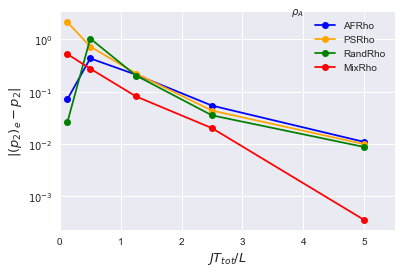

In [12]:
timeli = np.sort(np.array(Ereta2[Keys[0]].keys(),dtype='int'))
plt.plot(timeli/8.0,[Ereta2[Keys[0]][str(i)] for i in timeli],'bo-')
timeli = np.sort(np.array(Ereta2[Keys[1]].keys(),dtype='int'))
plt.plot(timeli/8.0,[Ereta2[Keys[1]][str(i)] for i in timeli],'o-',color='orange')
timeli = np.sort(np.array(Ereta2[Keys[2]].keys(),dtype='int'))
plt.plot(timeli/8.0,[Ereta2[Keys[2]][str(i)] for i in timeli],'go-')
timeli = np.sort(np.array(Ereta2[Keys[3]].keys(),dtype='int'))
plt.plot(timeli/8.0,[Ereta2[Keys[3]][str(i)] for i in timeli],'ro-')
plt.yscale('log')
plt.xlabel(r'$JT_{tot}/L$',fontsize=13)
plt.ylabel(r'$|(p_2)_e-p_2|$',fontsize=13)
plt.text(3.8,3,r'$\rho_A$')
plt.xlim(0,5.5)
#plt.ylim(0.001,12)
plt.legend(Keys[:4])
#plt.savefig('differentstates.pdf',format='pdf',orientation='portrait',papertype='executive')

In [16]:
EredifDisor={}

In [21]:
start=time.clock()
start0=start

for diso in []:
    EredifDisor[diso]=gen_vag_er(1,5,10,AFRho,disstre=diso,NU=500)
    print str(diso)+': ',EredifDisor[diso]
    print time.clock()-start,'s'
    start=time.clock()
    print '_'*50
    
print 'Total time: ',time.clock()-start0,'s'
print EredifDisor

Total time:  0.00060300000041 s
{0.5: 0.09662989410589938, 1: 0.35369314670371943, 2: 0.19578890701510471, 3: 0.14636527171080904, 0.1: 0.843823696081623, 0.8: 0.3438425495647246, 0.4: 0.12017805138705225, 0.6: 0.24733323118514955, 10: 1.8512834057914802, 0.3: 0.37909957211731599, 0.2: 0.64229599894695233, 0.7: 0.31778807873148546, 6: 0.58009566324097039, 5: 0.36182605817319957, 1.5: 0.28755203378396638}


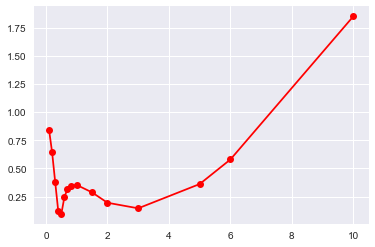

In [30]:
keyo=np.sort(EredifDisor.keys())
plt.plot(keyo,[EredifDisor[key] for key in keyo],'ro-')

In [479]:
start=time.clock()
start0=start

for i in np.linspace(9.5,10.5,2):
    quenchtime[str(i)]=gen_vag_er(i,30,10,NU=500)
    print str(i)+': ',quenchtime[str(i)]
    print time.clock()-start,'s'
    start=time.clock()
    
print 'Total time: ',time.clock()-start0,'s'

9.5:  0.0902619575842
1394.950583 s
10.5:  0.0686615708557
1476.057478 s
Total time:  2871.008529 s


In [492]:
totaltimes={}

In [493]:
start=time.clock()
start0=start

for i in np.array(np.linspace(5,50,10),dtype='int'):
    totaltimes[str(i)]=gen_vag_er(2,i,10,NU=500)
    print str(i)+': ',totaltimes[str(i)]
    print time.clock()-start,'s'
    start=time.clock()
    
print 'Total time: ',time.clock()-start0,'s'

5:  2.09806604632
140.555155 s
10:  0.704869739996
254.837883 s
15:  0.271150754263
373.873381 s
20:  0.149028301794
488.72595 s
25:  0.123062983389
602.208824 s
30:  0.10771693612
714.697281 s
35:  0.0968962269413
826.374881 s
40:  0.0662278014518
940.652077 s
45:  0.0961452594443
1053.866166 s
50:  0.0964785817344
1169.000328 s
Total time:  6564.793927 s


In [17]:
df=pd.DataFrame(Ereta2)
#df.to_csv('differentstates.csv')
df.sort_values(by=['PSRho','MixRho'])

,AFRho,MixRho,PSRho,RandRho
20,0.006171,0.004282,0.007967,0.007274
40,0.010918,0.004463,0.008812,0.007771
10,0.028450,0.033609,0.092121,0.010802
4,0.309752,0.422447,1.635409,0.383442
1,1.352248,1.827381,6.058484,1.096668


In [18]:
Ereta2

{'AFRho': {'1': 1.3522478133532632,
  '10': 0.028450250761197969,
  '20': 0.0061713890177917613,
  '4': 0.30975174673426747,
  '40': 0.01091791020996489},
 'MixRho': {'1': 1.8273812235980484,
  '10': 0.033608722622777178,
  '20': 0.0042823768870182801,
  '4': 0.42244701211291752,
  '40': 0.0044631900854864189},
 'PSRho': {'1': 6.0584836396461714,
  '10': 0.092121351899429021,
  '20': 0.0079667856145226677,
  '4': 1.6354090915932484,
  '40': 0.0088117659821985803},
 'RandRho': {'1': 1.0966681730276124,
  '10': 0.01080187051270688,
  '20': 0.0072740775019960024,
  '4': 0.38344197176476708,
  '40': 0.0077707259141835518}}

In [24]:
for keys, number in EredifDisor.items():
    print keys,number

0.5 0.0966298941059
1 0.353693146704
2 0.195788907015
3 0.146365271711
0.1 0.843823696082
0.8 0.343842549565
0.4 0.120178051387
0.6 0.247333231185
10 1.85128340579
0.3 0.379099572117
0.2 0.642295998947
0.7 0.317788078731
6 0.580095663241
5 0.361826058173
1.5 0.287552033784
